##### import library

In [1]:
import sys
sys.path.append("../../..")
# sys.path.append("../../../data/")

In [2]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import utility
import pingouin as pg
from pingouin import compute_effsize

##### Read file

In [3]:
# Load all the three data and concat them to get the final result
import pandas as pd
fabZ = pd.read_csv("../../../data/fabZ_complete_result_kgain.csv")
lpxC = pd.read_csv("../../../data/lpxC_complete_result_kgain.csv")
murA = pd.read_csv("../../../data/murA_complete_result_kgain.csv")# concat them 

final_result = pd.concat([fabZ,lpxC,murA])
final_result.drop(["FullDesignId", "Unnamed: 0"], axis=1, inplace=True)
final_result = final_result.drop_duplicates(subset=['TargetAaPosition', 'MutatedAa',
       'MutatedCodon', 'TargetAa', 'TargetCodon', 'CompetitionCoefficient',
       'fre_flank', 'alt_flank', "accumulated_gain",'GeneName'], keep="first")
final_result['CompetitionCoefficient'] = final_result['CompetitionCoefficient'].str.replace(',', '.').astype(float)
final_result['key'] = final_result['TargetAa'] + final_result['TargetAaPosition'].astype(str) + final_result['MutatedAa'] + final_result['GeneName']
final_result.head()

,GeneName,TargetAaPosition,MutatedAa,MutatedCodon,TargetAa,TargetCodon,CompetitionCoefficient,fre_flank,alt_flank,occurence,log_likelihood_gain,ref_sliding_window,alt_sliding_window,accumulated_gain,key
0,fabZ,4,A,GCG,N,AAC,0.014575,GACTACTAACACTCATA,GACTACTGCGACTCATA,6.0,0.916291,TAACACTCAT,TGCGACTCAT,2.813411,N4AfabZ
8,fabZ,4,C,TGC,N,AAC,-0.012498,GACTACTAACACTCATA,GACTACTTGCACTCATA,6.0,0.693147,TAACACTCAT,TTGCACTCAT,-3.988984,N4CfabZ
16,fabZ,4,D,GAT,N,AAC,-0.118355,GACTACTAACACTCATA,GACTACTGATACTCATA,5.0,1.871802,CTAACACTCA,CTGATACTCA,3.651139,N4DfabZ
24,fabZ,4,E,GAA,N,AAC,-0.612275,GACTACTAACACTCATA,GACTACTGAAACTCATA,5.0,1.704748,CTAACACTCA,CTGAAACTCA,2.860347,N4EfabZ
32,fabZ,4,F,TTT,N,AAC,-0.251570,GACTACTAACACTCATA,GACTACTTTTACTCATA,6.0,2.197225,TAACACTCAT,TTTTACTCAT,2.772589,N4FfabZ


##### import tolerance score

In [4]:
# Sample DataFrame (assuming 'tol' is already loaded)
def categorize_rsa(value):
    if pd.isna(value):  # Handling NaN values
        return np.nan
    # if value == 0:
    #     return "Low RSA"
    if 0 <= value <= 1:
        return "buried"
    if value > 1:
        return "Surface exposed"

In [5]:
tol = pd.read_csv("../../../data//41467_2023_35940_MOESM8_ESM.csv")
tol['MutatedAa'] = tol['MutatedAa'].str.split(',')
tol = tol.explode('MutatedAa').reset_index(drop=True)
tol['key'] = tol['TargetAa'] + tol['TargetAaPosition'].astype(str) + tol['MutatedAa'] + tol['GeneName']
tol.head()
# Apply function to create a new column
tol["RSA_Category"] = tol["RSA"].apply(categorize_rsa)

In [6]:
# Make key of col TargetAa TargetAaPosition and mutatedAa for fabZ_ab
# tol['key'] = tol['Residue'] + tol['Allowed substitutions'] + tol['Protein']
tol

,GeneName,TargetAa,TargetAaPosition,ToleranceScore,MutatedAa,RSA,Annotation,key,RSA_Category
0,fabZ,T,2,0.95,A,NaN,NaN,T2AfabZ,NaN
1,fabZ,T,2,0.95,C,NaN,NaN,T2CfabZ,NaN
2,fabZ,T,2,0.95,D,NaN,NaN,T2DfabZ,NaN
3,fabZ,T,2,0.95,E,NaN,NaN,T2EfabZ,NaN
4,fabZ,T,2,0.95,F,NaN,NaN,T2FfabZ,NaN
...,...,...,...,...,...,...,...,...,...
13962,murA,E,419,1.00,S,NaN,NaN,E419SmurA,NaN
13963,murA,E,419,1.00,T,NaN,NaN,E419TmurA,NaN
13964,murA,E,419,1.00,V,NaN,NaN,E419VmurA,NaN
13965,murA,E,419,1.00,W,NaN,NaN,E419WmurA,NaN


##### Generate dataframe with Gene vs kGain and Tolerance score

In [7]:
tmp_gene = final_result.merge(tol.drop(["Annotation"], axis=1).drop_duplicates(), on = ['GeneName', 'TargetAa', 'TargetAaPosition', 
       'MutatedAa', 'key'], how = "left")

In [8]:
tmp_gene.head()

,GeneName,TargetAaPosition,MutatedAa,MutatedCodon,TargetAa,TargetCodon,CompetitionCoefficient,fre_flank,alt_flank,occurence,log_likelihood_gain,ref_sliding_window,alt_sliding_window,accumulated_gain,key,ToleranceScore,RSA,RSA_Category
0,fabZ,4,A,GCG,N,AAC,0.014575,GACTACTAACACTCATA,GACTACTGCGACTCATA,6.0,0.916291,TAACACTCAT,TGCGACTCAT,2.813411,N4AfabZ,1.0,NaN,NaN
1,fabZ,4,C,TGC,N,AAC,-0.012498,GACTACTAACACTCATA,GACTACTTGCACTCATA,6.0,0.693147,TAACACTCAT,TTGCACTCAT,-3.988984,N4CfabZ,1.0,NaN,NaN
2,fabZ,4,D,GAT,N,AAC,-0.118355,GACTACTAACACTCATA,GACTACTGATACTCATA,5.0,1.871802,CTAACACTCA,CTGATACTCA,3.651139,N4DfabZ,1.0,NaN,NaN
3,fabZ,4,E,GAA,N,AAC,-0.612275,GACTACTAACACTCATA,GACTACTGAAACTCATA,5.0,1.704748,CTAACACTCA,CTGAAACTCA,2.860347,N4EfabZ,1.0,NaN,NaN
4,fabZ,4,F,TTT,N,AAC,-0.251570,GACTACTAACACTCATA,GACTACTTTTACTCATA,6.0,2.197225,TAACACTCAT,TTTTACTCAT,2.772589,N4FfabZ,1.0,NaN,NaN


##### Binarize the tolerance category with 0.8 as tolerance cut off

In [9]:
tmp_gene["tolerance_category"]  = tmp_gene["ToleranceScore"].apply(lambda x: "Tolerant" if x>=1 else "Intolerant")


In [10]:
tmp_gene = tmp_gene.sort_values(by='tolerance_category', ascending=False)
tmp_gene.reset_index(inplace=True, drop = True)

In [11]:
tmp_gene.head()

,GeneName,TargetAaPosition,MutatedAa,MutatedCodon,TargetAa,TargetCodon,CompetitionCoefficient,fre_flank,alt_flank,occurence,log_likelihood_gain,ref_sliding_window,alt_sliding_window,accumulated_gain,key,ToleranceScore,RSA,RSA_Category,tolerance_category
0,fabZ,4,A,GCG,N,AAC,0.014575,GACTACTAACACTCATA,GACTACTGCGACTCATA,6.0,0.916291,TAACACTCAT,TGCGACTCAT,2.813411,N4AfabZ,1.0,NaN,NaN,Tolerant
1,lpxC,288,P,CCG,Q,CAG,0.421401,GACCTTCCAGGACGACG,GACCTTCCCGGACGACG,2.0,0.693147,CCTTCCAGGA,CCTTCCCGGA,1.360398,Q288PlpxC,1.0,59.61,Surface exposed,Tolerant
2,lpxC,287,T,ACC,F,TTC,-0.042615,TGTGACCTTCCAGGACG,TGTGACCACCCAGGACG,5.0,0.693147,CCTTCCAGGA,CCACCCAGGA,-4.833191,F287TlpxC,1.0,9.94,Surface exposed,Tolerant
3,lpxC,287,V,GTG,F,TTC,-0.202747,TGTGACCTTCCAGGACG,TGTGACCGTGCAGGACG,5.0,1.386294,CCTTCCAGGA,CCGTGCAGGA,-1.023105,F287VlpxC,1.0,9.94,Surface exposed,Tolerant
4,lpxC,287,W,TGG,F,TTC,-0.056582,TGTGACCTTCCAGGACG,TGTGACCTGGCAGGACG,6.0,1.673976,CTTCCAGGAC,CTGGCAGGAC,1.705229,F287WlpxC,1.0,9.94,Surface exposed,Tolerant


##### fig S5a. Plot median kGain heatmap and tolerance score heatmap for lpxC

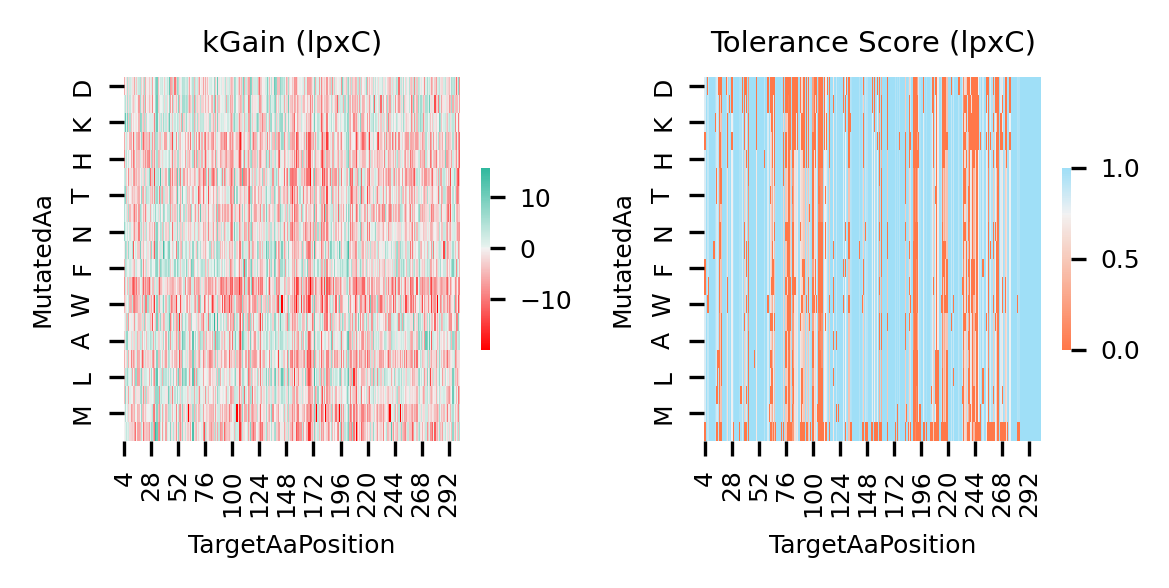

In [12]:
plt.rcParams.update({
    "axes.titlesize": 8,       # Font size of axes titles
    "axes.labelsize": 6,        # Font size of x and y labels
    "xtick.labelsize": 6,       # Font size of x-axis tick labels
    "ytick.labelsize": 6,       # Font size of y-axis tick labels
    "legend.fontsize": 8,       # Font size of legend
    "font.size": 8,
    "axes.edgecolor": "lightgray",  # Lighter axis lines
    "grid.color": "lightgray",     # Lighter grid
    "figure.facecolor": "white",   # Lighter background
})

fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)  # Adjust subplot for one gene

cmap_kgain = sns.diverging_palette(25, 180, l=50, s=400, as_cmap=True)
cmap_tolerance = sns.diverging_palette(20, 240, l=70, s=150, as_cmap=True)

# Define amino acid order
amino_acid_order = ["D", "E", "K", "R", "H", "S", "T", "C", "N", "Q", "F", "Y", "W", "G", "A", "V", "L", "I", "M", "P"]

# Filter data for the specific gene: murA
gene = "lpxC"
df_gene = tmp_gene[tmp_gene["GeneName"] == gene]

# Aggregate data to handle duplicates
df_agg = (
    df_gene.groupby(["MutatedAa", "TargetAaPosition"], as_index=False)
    .agg(
        accumulated_gain=("accumulated_gain", "median"),
        ToleranceScore=("ToleranceScore", "median"),
    )
)

df_agg["MutatedAa"] = pd.Categorical(df_agg["MutatedAa"], categories=amino_acid_order, ordered=True)

# Pivot for the heatmaps
heatmap_data_gain = df_agg.pivot(index="MutatedAa", columns="TargetAaPosition", values="accumulated_gain")
heatmap_data_tolerance = df_agg.pivot(index="MutatedAa", columns="TargetAaPosition", values="ToleranceScore")

# Fill NaN values with the minimum value of the dataset
heatmap_data_gain = heatmap_data_gain.fillna(heatmap_data_gain.min().min())
heatmap_data_tolerance = heatmap_data_tolerance.fillna(heatmap_data_tolerance.min().min())


# Adjust center for ToleranceScore based on its data range
tolerance_center = heatmap_data_tolerance.stack().mean()  # Use the mean as the center

# Heatmap for kGain
sns.heatmap(
    heatmap_data_gain,
    cmap=cmap_kgain,
    linecolor="gray",
    ax=axes[0],
    cbar_kws={"shrink": 0.5},
    center=0
)
axes[0].set_title(f"kGain ({gene})", fontsize=7)

# Heatmap for ToleranceScore
axes[1] = sns.heatmap(
    heatmap_data_tolerance,
    cmap=cmap_tolerance,
    linecolor="gray",
    ax=axes[1],
    cbar_kws={"shrink": 0.5},
    center=tolerance_center ,
)
axes[1].set_title(f"Tolerance Score ({gene})", fontsize=7)
plt.tight_layout()
plt.show()


##### fig S5b. Plot median kGain heatmap and tolerance score heatmap for fabZ

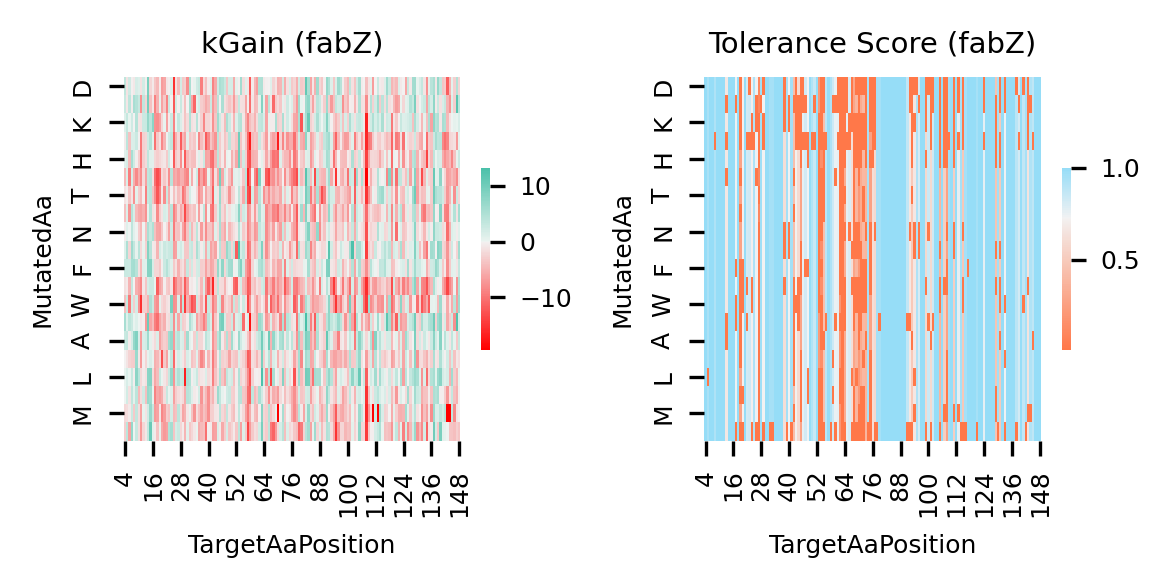

In [13]:
plt.rcParams.update({
    "axes.titlesize": 8,       # Font size of axes titles
    "axes.labelsize": 6,        # Font size of x and y labels
    "xtick.labelsize": 6,       # Font size of x-axis tick labels
    "ytick.labelsize": 6,       # Font size of y-axis tick labels
    "legend.fontsize": 8,       # Font size of legend
    "font.size": 8,
    "axes.edgecolor": "lightgray",  # Lighter axis lines
    "grid.color": "lightgray",     # Lighter grid
    "figure.facecolor": "white",   # Lighter background
})

fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)  # Adjust subplot for one gene

cmap_kgain = sns.diverging_palette(25, 180, l=50, s=400, as_cmap=True)
cmap_tolerance = sns.diverging_palette(20, 240, l=70, s=150, as_cmap=True)

# Define amino acid order
amino_acid_order = ["D", "E", "K", "R", "H", "S", "T", "C", "N", "Q", "F", "Y", "W", "G", "A", "V", "L", "I", "M", "P"]

# Filter data for the specific gene: murA
gene = "fabZ"
df_gene = tmp_gene[tmp_gene["GeneName"] == gene]

# Aggregate data to handle duplicates
df_agg = (
    df_gene.groupby(["MutatedAa", "TargetAaPosition"], as_index=False)
    .agg(
        accumulated_gain=("accumulated_gain", "median"),
        ToleranceScore=("ToleranceScore", "median"),
    )
)

df_agg["MutatedAa"] = pd.Categorical(df_agg["MutatedAa"], categories=amino_acid_order, ordered=True)

# Pivot for the heatmaps
heatmap_data_gain = df_agg.pivot(index="MutatedAa", columns="TargetAaPosition", values="accumulated_gain")
heatmap_data_tolerance = df_agg.pivot(index="MutatedAa", columns="TargetAaPosition", values="ToleranceScore")

# Fill NaN values with the minimum value of the dataset
heatmap_data_gain = heatmap_data_gain.fillna(heatmap_data_gain.min().min())
heatmap_data_tolerance = heatmap_data_tolerance.fillna(heatmap_data_tolerance.min().min())


# Adjust center for ToleranceScore based on its data range
tolerance_center = heatmap_data_tolerance.stack().mean()  # Use the mean as the center

# Heatmap for kGain
sns.heatmap(
    heatmap_data_gain,
    cmap=cmap_kgain,
    linecolor="gray",
    ax=axes[0],
    cbar_kws={"shrink": 0.5},
    center=0
)
axes[0].set_title(f"kGain ({gene})", fontsize=7)

# Heatmap for ToleranceScore
axes[1] = sns.heatmap(
    heatmap_data_tolerance,
    cmap=cmap_tolerance,
    linecolor="gray",
    ax=axes[1],
    cbar_kws={"shrink": 0.5},
    center=tolerance_center ,
)
axes[1].set_title(f"Tolerance Score ({gene})", fontsize=7)
plt.tight_layout()
plt.show()


##### fig S5 c, d, e: kGain vs tolerance category

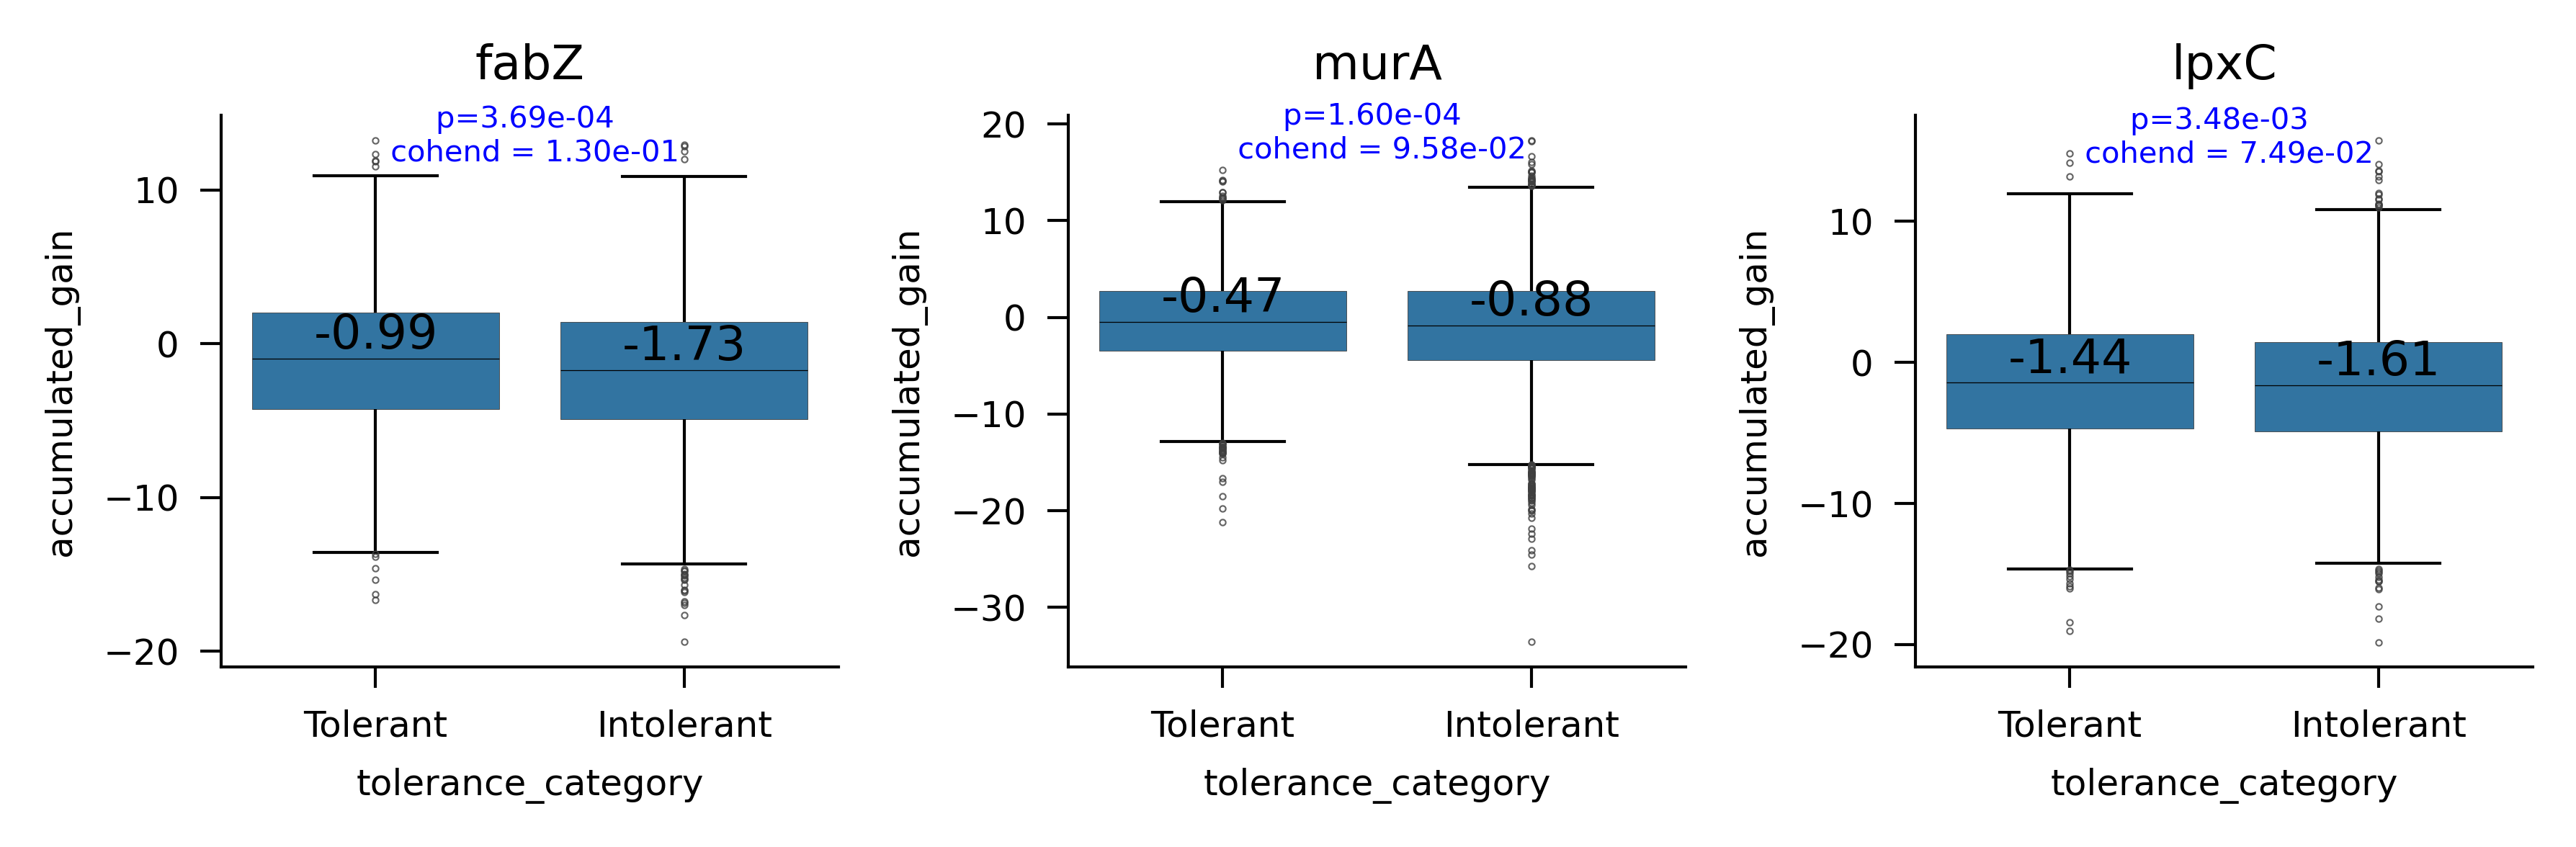

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2), dpi = 600)
c = 0

for gene_name in list(set(tmp_gene["GeneName"])):

    tmp = None
    tmp = tmp_gene[tmp_gene["GeneName"]==gene_name]
    
    

    axes[c].set_title(gene_name, fontsize = 8)
    axes[c]=sns.boxplot(data=tmp, x='tolerance_category', y='accumulated_gain',ax= axes[c], linewidth=0.1, 
                        whiskerprops=dict(color="black", linewidth=0.5),  capprops=dict(color="black", linewidth=0.5),  
                        medianprops=dict(color="black", linewidth=0.15), 
                        flierprops=dict(marker="o", color="black", markersize=0.25, alpha=0.8),
                        dodge=True)

    # # Extract groups
    group_tolerant = tmp[tmp["tolerance_category"] == "Tolerant"]["accumulated_gain"].dropna()
    group_intolerant = tmp[tmp["tolerance_category"] == "Intolerant"]["accumulated_gain"].dropna()
    
    cohend = pg.compute_effsize(group_tolerant, group_intolerant, eftype='cohen')
    # Calculate p-values for one-sided Mann-Whitney U test
    if not group_tolerant.empty and not group_intolerant.empty:
        p_value = utility.man_whiteney(group_tolerant, group_intolerant)
        axes[c].text(
            0.5, 
            tmp["accumulated_gain"].max() * 0.9,  # Adjust placement of p-value
            f'p={p_value:.2e} \n cohend = {cohend:.2e}', 
            ha='center', 
            fontsize=5, 
            color="blue"
        )
  
        # Annotate medians on top of each box
    medians = tmp.groupby("tolerance_category")["accumulated_gain"].median()
    for idx, category in enumerate(["Tolerant", "Intolerant"]):
        if category in medians.index:
            axes[c].text(
                idx, 
                medians[category], 
                f'{medians[category]:.2f}', 
                ha='center', 
                va='bottom', 
                fontsize=8, 
                color="black")

    axes[c]  = utility.custom_figure_axis(axes[c], fontsize=6, show_ticks = True, rotation=0)


    c = c+1



plt.tight_layout()


##### fig S5f: kGain vs Gene with RSA as hue

x: fabZ, p-value: 1.79e-02, Cohen's d: 9.55e-02
x: lpxC, p-value: 2.22e-01, Cohen's d: 3.98e-02
x: murA, p-value: 1.87e-05, Cohen's d: 1.29e-01


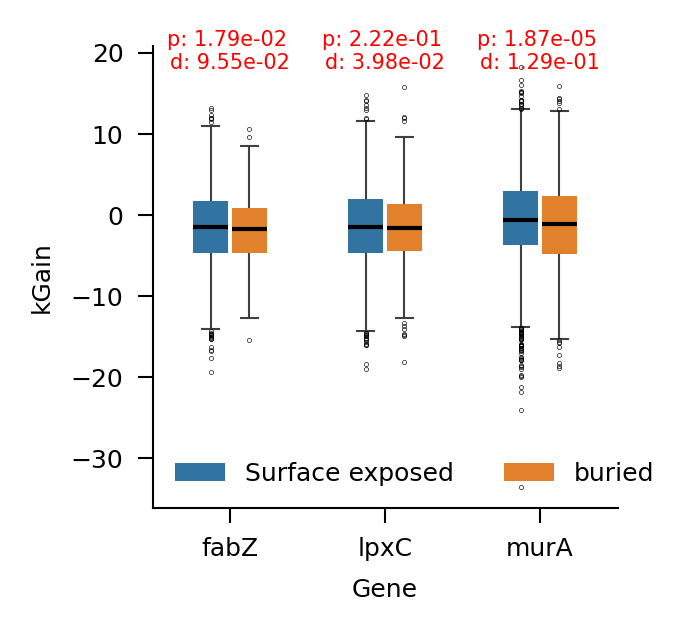

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)  # Adjust subplot for one gene

ax = sns.boxplot(data = tmp_gene, ax=ax, x ='GeneName', hue = 'RSA_Category', y = 'accumulated_gain', boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.5,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1} , gap=0.1)
ax = utility.custom_figure_axis(ax=ax, fontsize=6, rotation = 0)
ax.legend(fontsize = 6, ncol=2, frameon=False)
ax.set_ylabel("kGain")
ax.set_xlabel("Gene")

ax = utility.return_box_with_p_effect_size(ax=ax, data = tmp_gene, x_columns = 'GeneName',hue_columns = 'RSA_Category', y_columns ='accumulated_gain', group1_name = "Surface exposed", group2_name = "buried", y_pos= 18, fontsize = 5)
